# Resampling for regression (resreg) tutorial
## Tutorial 01 - Basics: rare and normal domains, relevance functions, and performance evaluation

In this tutorial, we will apply the resreg module to improve predictive performance on rare high target values with the California housing dataset.

### Import libaries and dataset

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import fetch_california_housing as dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert(1, '..')
import resreg

### Retrieve dataset and view distribution
We will use only 500 samples randomly selected from the full dataset of 20,640 samples.

Text(0, 0.5, 'Frequency')

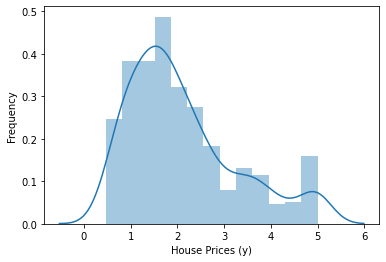

In [2]:
data = dataset()
X = data.data
y = data.target
np.random.seed(seed=0)
sample = np.random.choice(range(len(y)), 500)
X, y = X[sample,:], y[sample]

# View distribution
sns.distplot(y)
plt.xlabel('House Prices (y)')
plt.ylabel('Frequency')

As you can see from the plot, the target values (y) follow a normal distribution with abundant values centered about the median and rare values at the extremes (tails). Because there are fewer samples at the extremes, a regressor will tend to perform worse on rare values than on abundant (normal) values.

### The relevance function

To deal with the skewness of the data due to the normal distribution, we will split the data into two domains: a normal domain with abundant target values and a rare domain with sparse target values. The data is split into the domains by using a relevance function. The relevance function maps the target values to a scale from 0 to 1, where 1 indicates maximum relevance. Instances with relevance values greater than a specified threshold form the rare domain, which is of greater relvance to the user, while the rest of the data form the normal domain. Consequently, the data can be resampled by oversampling the rare domain and undersampling the normal domain.

Three kind of relevance functions can be used:

__1. Step relevance function__: Target values above/below certain levels are assigned high relevance. We may choose to form a rare domain from both left and right tails of the distribution. Or, if we are mostly concerned about predicting high prices, we can form the rare domain from only the right tail. Here, let us use target values below 1.0 and above 3.5 as the left and right tail, respectively.

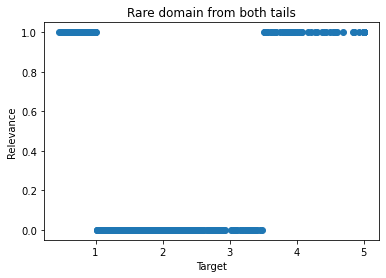

Text(0.5, 1.0, 'Rare domain from right tail')

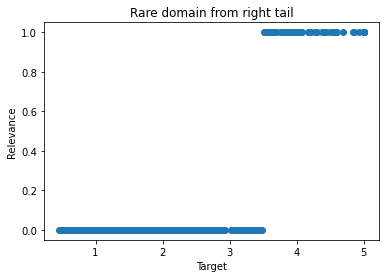

In [3]:
low_y = 1.0  # Rare domain boundary for left tail
high_y = 3.5 # Rare domain boundary for right tail

# Instances with target values in rare domain have a relevance value of 1, all others have 
# a relevance value of 0
relevance_both = (y >= high_y) + (y <= low_y)
relevance_right = (y >= high_y)

# Plot two-sided relevance function (left and right tails)
plt.scatter(y, relevance_both)
plt.ylabel('Relevance')
plt.xlabel('Target')
plt.title('Rare domain from both tails')
plt.show()
plt.close()

# Plot right-sided relevance function (right tail only)
plt.scatter(y, relevance_right)
plt.ylabel('Relevance')
plt.xlabel('Target')
plt.title('Rare domain from right tail')

__2. Sigmoid relevance function__: Rather than use a step relevance function, a sigmoid relevance function achieves a smoother curve. A smooth curve is important if you will use the relevance values later on as sampling weights. 

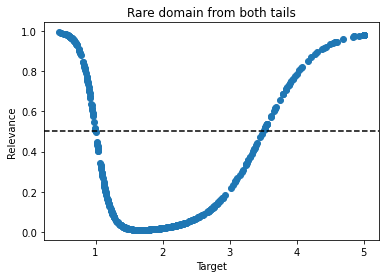

Text(0.5, 1.0, 'Rare domain from right tail')

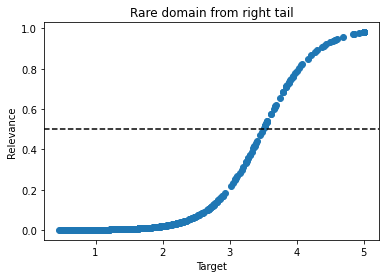

In [4]:
low_y = 1.0  # Rare domain boundary for left tail
high_y = 3.5 # Rare domain boundary for right tail

# Instances in the rare domain have relevance values above 0.5 
# and other instances have relevance values below 0.5.
# cl and ch are the low and high centers of the sigmoid curve
relevance_both = resreg.sigmoid_relevance(y, cl=low_y, ch=high_y)
# Put cl=None for a right-sided relevance function, and ch=None for left-sided
relevance_right = resreg.sigmoid_relevance(y, cl=None, ch=high_y) 

# Plot two-sided relevance values (left and right tails)
plt.scatter(y, relevance_both)
plt.axhline(0.5, linestyle='--', color='black')
plt.ylabel('Relevance')
plt.xlabel('Target')
plt.title('Rare domain from both tails')
plt.show()
plt.close()

# Plot right-sided relevance function (right tail only)
plt.scatter(y, relevance_right)
plt.axhline(0.5, linestyle='--', color='black')
plt.ylabel('Relevance')
plt.xlabel('Target')
plt.title('Rare domain from right tail')

__3. PDF relevance function__: This uses the normalized inverse of the probability density function (PDF) as the relevance values. The density function is fitted with `sklearn.neighbors.KernelDensity`. Unlike the sigmoid relevance function, in which the rare domain instances all have relevance values above 0.5, with the PDF relevance function, you have to select a relevance threshold and choose rare instances that meet the threshold.

With bandwidth=0.5 at relevance threshold of 0.5,
rare domain: y<0.668 and y>2.558

With bandwidth=0.1 at relevance threshold of 0.5,
rare domain: y<0.641 and y>2.347


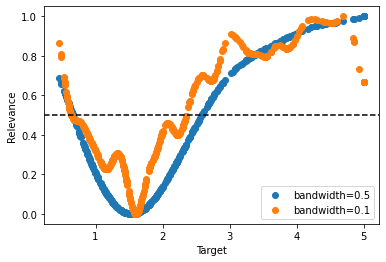

In [5]:
# The bandwidth parameter determines the smoothness of the relevance curve
# Higher bandwidth values imply a smoother curve
relevance_pdf1 = resreg.pdf_relevance(y, bandwidth=0.5)
relevance_pdf2 = resreg.pdf_relevance(y, bandwidth=0.1)
threshold = 0.5
y_norm_domain1 = y[np.where(relevance_pdf1<0.5)[0]]
y_norm_domain2 = y[np.where(relevance_pdf2<0.5)[0]]
print('With bandwidth=0.5 at relevance threshold of 0.5,'
      f'\nrare domain: y<{min(y_norm_domain1)} and y>{max(y_norm_domain1)}')
print('\nWith bandwidth=0.1 at relevance threshold of 0.5,'
      f'\nrare domain: y<{min(y_norm_domain2)} and y>{max(y_norm_domain2)}')


# Plot PDF relevance values
plt.scatter(y, relevance_pdf1, label='bandwidth=0.5')
plt.scatter(y, relevance_pdf2, label='bandwidth=0.1')
plt.axhline(0.5, linestyle='--', color='black')
plt.legend()
plt.ylabel('Relevance')
plt.xlabel('Target')
plt.show()
plt.close()


### Performance evaluation for regression on imbalanced data

With imbalanced distributions, performance metrics such as correlation coefficient ($r$), coefficient of determination ($r^{2}$), and mean squared error (MSE) are heavily biased towards abundant values (normal domain). As a result, these metrics may fail to capture the poorer performance at on the sparse values (rare domain). If rare values are more important to the user, it is important to ensure that the evaluation metrics sufficiently capture the performance on rare values. The following techniques may be used:

__1. Use a uniformly distributed testing set__: A nearly uniformly distributed testing set can be constructed by dividing the target values into bins and then selecting the same number of samples from each bin for the test set. The remaining samples can be used in training. The function, `bin_split`, splits the data into bins and returns the indices of the instances in each bin, and the frequency of each bin. The function, `uniform_test_split`, splits the data in each bin to a training set and a uniformly distributed testing set.


In [6]:
# Split the data into bins and view the distribution of each bin
# Specify the bin boundaries as a list
bin_indices, bin_freqs = resreg.bin_split(y, bins=[1.5, 2.5, 3.5, 4.5])
print(bin_freqs)

       bin range frequency percent
0        y < 1.5       173    34.6
1  1.5 ≤ y < 2.5       188    37.6
2  2.5 ≤ y < 3.5        64    12.8
3  3.5 ≤ y < 4.5        42     8.4
4        y ≥ 4.5        33     6.6
5          TOTAL       500     100


From each bin, we select an equal number of samples for a uniform test set and use the rest for training with `uniform_test_split`. Since the smallest bin has 33 samples, we should select less than 33 samples from each bin for testing. The number of samples to select from each bin can be specified as an integer (e.g. 10) or as a float (i.e. the fraction of the smallest bin).

In [7]:
# Select half (0.5) of the smallest bin (i.e., 16 samples) from each bin as test.
# Setting verbose to True prints out the frequency of training and 
# testing set for each bin.
bins = [1.5, 2.5, 3.5, 4.5]
train_indices, test_indices = resreg.uniform_test_split(X, y, bins=bins,
                                        bin_test_size=0.5, verbose=True,
                                        random_state=0)
X_train, y_train = X[train_indices,:], y[train_indices]
X_test, y_test = X[test_indices,:], y[test_indices]
print(f'Training set has {len(y_train)} samples')
print(f'Testing set has {len(y_test)} samples')



     bin range train size test size
       y < 1.5        157        16
 1.5 ≤ y < 2.5        172        16
 2.5 ≤ y < 3.5         48        16
 3.5 ≤ y < 4.5         26        16
       y ≥ 4.5         17        16
         TOTAL        420        80


Training set has 420 samples
Testing set has 80 samples


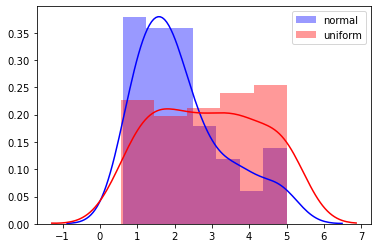

In [8]:
# Compare uniform test set with a randomly selected test set
X_train, X_test, y_train, y_test_normal = train_test_split(X, y, test_size=80, 
                                                            random_state=0)
sns.distplot(y_test_normal, color='blue', label='normal') # randomly selected
sns.distplot(y_test, color='red', label='uniform') # uniformly selected
plt.legend()

The dataset can be split into training and uniform testing sets repeatedly, a regressor fit to the training set and evaluated on the test set, and the performance averaged over all repeated splits (i.e., Monte Carlo Cross Validation).

__2. Evaluate the F1 score__:

The F1 score, which is the harmonic mean of the precision and recall, can be evaluated for regression problems. First, an error threshold is specified so that predicted values within the error threshold of the true values are defined as correct. Recall is a measure of the fraction of rare values that are correctly predicted, and recall is a fraction of predicted rare values that are correct. Both recall and precision are weighted by the relevance values (which is why a smooth relevance function is preferred to a step relevance function). Hence, the F1 score is a relevance-weighted measure of the predictive accuracy on the rare domain.

We will apply a random forest regressor and determine the F1 score on predictions.

recall = 0.31
precision = 0.519
f1 = 0.388


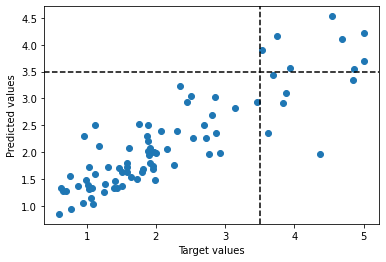

In [9]:
# Train random forest regressor and apply to test set
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=80, random_state=0)
reg = RandomForestRegressor(n_estimators=50, max_features=0.5, n_jobs=-1, random_state=0)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

# Determine relevance values of y_test and y_pred
# We will use a right-sided relevance function so that the 
# rare domain is formed from target values above 3.5.
rel_test = resreg.sigmoid_relevance(y_test, cl=None, ch=3.5)
rel_pred = resreg.sigmoid_relevance(y_pred, cl=None, ch=3.5)

# Calculate the F1 score. 
# A relevance threshold of 0.5 ensures that target values above 3.5 form the 
# rare domain. An error threshold of 0.5 means that predictions within 0.5 of
# the true values are correct. The k parameter determines the smoothness of the 
# relevance weights. A very high k value implies a steep curve so that high 
# values get the maximum weights possible.
precision = resreg.precision_score(y_test, y_pred, error_threshold=0.5,
                    relevance_pred=rel_pred, relevance_threshold=0.5, k=10000)
recall = resreg.recall_score(y_test, y_pred, error_threshold=0.5, 
                    relevance_true=rel_test, relevance_threshold=0.5, k=10000)
f1 = resreg.f1_score(y_test, y_pred, error_threshold=0.5, relevance_true=rel_test,
                    relevance_pred=rel_pred, relevance_threshold=0.5, k=10000)

print(f'recall = {round(recall,3)}')
print(f'precision = {round(precision,3)}')
print(f'f1 = {round(f1,3)}')


plt.scatter(y_test, y_pred)
plt.xlabel('Target values')
plt.ylabel('Predicted values')
plt.axhline(3.5, linestyle='--', color='black')
plt.axvline(3.5, linestyle='--', color='black')


From the plot, you can see that many of the true rare domain values (> 3.5) are wrongly predicted, hence low recall (0.25). But predicted rare domain values are mostly true rare domain values and are within the error threshold (0.5), hence higher precision (0.40).

__3. Evaluate the performance for different bins__: Since an overall performance metric (MSE, r, r$^2$, etc) is usually biased towards abundant values, you can calculate the performance over different bins to evaluate the performance on rare data.

Overall MSE = 0.3820543742291159


Text(0, 0.5, 'Mean squared error (MSE)')

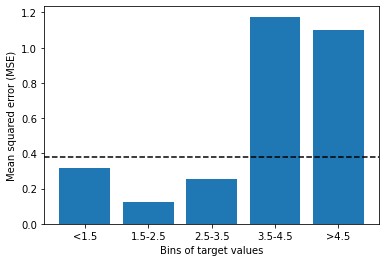

In [12]:
# Overall mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Overall MSE = {mse}')

# MSE over different bins
bins = [1.5, 2.5, 3.5, 4.5]
msebins = resreg.bin_performance(y_test, y_pred, bins=bins, metric='mse')

# Plot MSE
bin_names = ['<1.5', '1.5-2.5', '2.5-3.5', '3.5-4.5', '>4.5']
plt.bar(range(len(bin_names)), msebins)
plt.axhline(mse, color='black', linestyle='--')
_ = plt.xticks(range(len(bin_names)), bin_names)
plt.xlabel('Bins of target values')
plt.ylabel('Mean squared error (MSE)')

From the plot, you can see that although the overall MSE is 0.39 (dashed black line), it is strongly biased by the abundant values and does not adequately capture the error on rare high values (>3.5). The MSE on target values above 3.5 is about three times the overall MSE. If the user cares more about predicting high values, it is important to address the imbalance due to the normal distribution in order to improve the performance on high values.

In the next tutorial, we will go over resampling techniques that address the data imbalance and improve the predictive performance on high rare values (>3.5).